# IPython Notebook for partial analysis of Lausanne Marathon dataset

Main topics:
- qualitative distribution of age vs sex of the participants; Kolmogorov-Smirnov and Kruskal-Wallis statistical (non-parametric) tests to verify equal distribution assumption
- import from Wikipedia the most of Swiss cities along with their population, in order to investigate possible relations between the number of runners from each city and its population
- scrape with Google API the geographical coordinates of each city in the dataset. The purpose is twofold:
     1. Introduce coordinates into the dataset to build a leaflet map of Switzerland with Folium, in order to visualize the geographical provenience of Swiss runners;
     2. Qualitative "gravitational" model to link number of participants from a certain city, its population and its distance from the competition place (Lausanne)

**NOTE**:
the scraping part has the aim of defining intermediate datasets for the analysis. The actually useful one is named *complete_geography.csv* and has been loaded in the public repo along with the Lausanne Marathon dataset.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')

In [2]:
data = pd.read_csv('lausanne_marathon_2016.csv')
data.head()

,Unnamed: 0,cat,sex,rang,nom,an,lieu,temps,retard,pace
0,0,21,M,147,Abaidia Jilani,1966,St-Légier-La Chiésaz,"1:45.28,4","25.56,8",4.59
1,1,21,F,81,Abaidia Sandrine,1972,St-Légier,"1:49.40,8","24.09,5",5.11
2,2,False,F,33,Abaidia Selma,2006,St-Légier-La Chiésaz,"7.12,2","1.36,3",4.48
3,3,21,M,103,Abb Jochen,1948,Ernen,"2:50.40,7","1:21.28,7",8.05
4,4,10,M,426,Abbas Dhia,1961,Lausanne,"1:13.04,1","38.13,0",7.18


## Stats on age and sex

In this section the age of ther participants is examined per sex and category (10 km, 21 km, 42 km).

In [3]:
age = 2016-data.an.astype(int)
data['age']=age

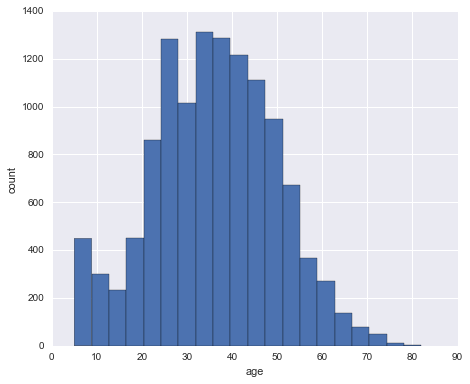

In [4]:
# get age of participants and plot its distribution
plt.subplot(1,2,1)
plt.hist(age,bins=20)
plt.gca().set_xlabel('age')
plt.gca().set_ylabel('count')
plt.gcf().set_size_inches(16,6)

Now compare the age distribution for women and men:

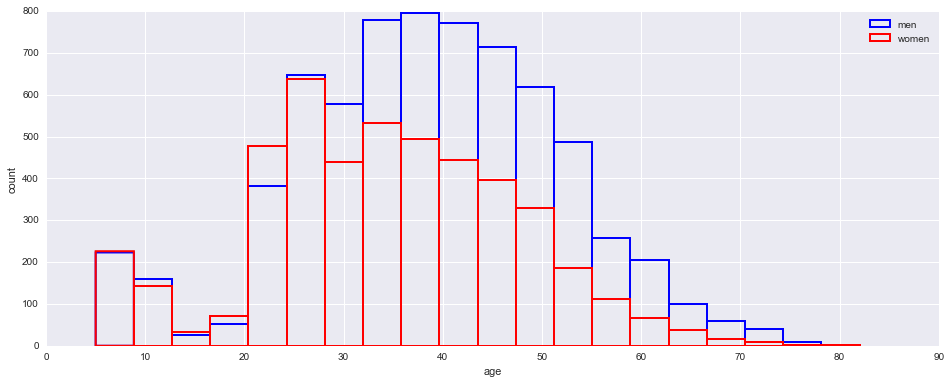

In [5]:
age_women = 2016 - data[data.sex=='F'].an.astype(int)
age_men = 2016 - data[data.sex=='M'].an.astype(int)
plt.hist(age_men,edgecolor='blue',fill=False,linewidth=2,label='men',bins=20)
plt.hist(age_women,edgecolor='red',fill=False,linewidth=2,label='women',bins=20)
plt.xlabel('age')
plt.ylabel('count')
plt.gca().set_xlim([0,90])
plt.gcf().set_size_inches(16,6)
plt.legend()

Clean data from 'False' (walk, kids running):

In [4]:
del data['Unnamed: 0']
data = data[data.cat != 'False']

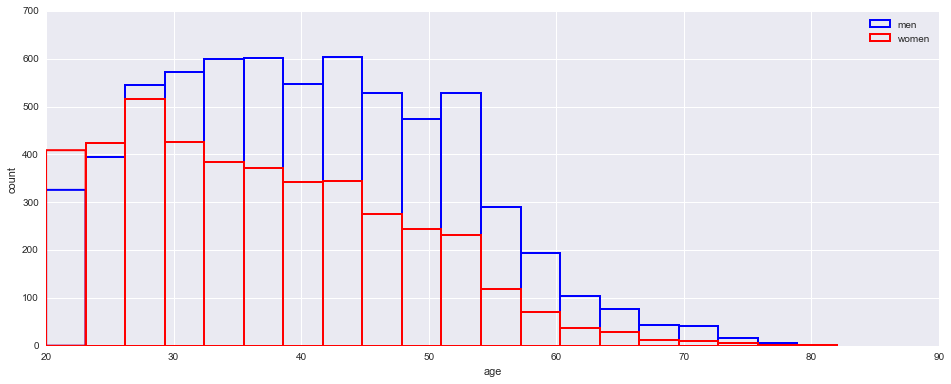

In [7]:
age_women = 2016 - data[data.sex=='F'].an.astype(int)
age_men = 2016 - data[data.sex=='M'].an.astype(int)
plt.hist(age_men,edgecolor='blue',fill=False,linewidth=2,label='men',bins=20)
plt.hist(age_women,edgecolor='red',fill=False,linewidth=2,label='women',bins=20)
plt.xlabel('age')
plt.ylabel('count')
plt.gca().set_xlim([20,90])
plt.gcf().set_size_inches(16,6)
plt.legend()

Sex-based statistical tests by category:

In [8]:
from scipy import stats
ks_stats = []
ks_pvalues = []
kw_stats = []
kw_pvalues = []
kstest = stats.ks_2samp(2016-data[data.sex=='M'].an.astype(int),2016-data[data.sex=='F'].an.astype(int))
ks_stats.append(kstest[0])
ks_pvalues.append(kstest[1])
kwtest = stats.mstats.kruskalwallis(2016-data[data.sex=='M'].an.astype(int),2016-data[data.sex=='F'].an.astype(int))
kw_stats.append(kwtest[0])
kw_pvalues.append(kwtest[1])

for i in ['10','21','42']:
    subdata = data[data.cat==i]
    kstest = stats.ks_2samp(2016-subdata[subdata.sex=='M'].an.astype(int),2016-subdata[subdata.sex=='F'].an.astype(int))
    ks_stats.append(kstest[0])
    ks_pvalues.append(kstest[1])
    kwtest = stats.mstats.kruskalwallis(2016-subdata[subdata.sex=='M'].an.astype(int),2016-subdata[subdata.sex=='F'].an.astype(int))
    kw_stats.append(kwtest[0])
    kw_pvalues.append(kwtest[1])

test = {'KS stat' : pd.Series(ks_stats), 'KS p-value' : pd.Series(ks_pvalues), 'category' : pd.Series(['global','10','21','42']), 'KW stat' : pd.Series(kw_stats), 'KW p-value' : pd.Series(kw_pvalues)}
test_result = pd.DataFrame(test)
test_result = test_result.set_index('category')
test_result

,KS p-value,KS stat,KW p-value,KW stat
category,,,,
global,1.010906e-40,0.134037,6.411120e-62,275.726303
10,3.487088e-23,0.142575,3.143475e-35,153.392881
21,2.448399e-08,0.096879,1.339886e-11,45.755268
42,8.376947e-04,0.144672,6.268202e-05,16.019844


# Scraping geographical data

In this section we import some information about Swiss cities (geo-coordinates, population) using the *Requests* library.

First parsing of geographical cordinates. WARN: invalid key reported. The output is a geography.csv file, containing the cities' name and coordinates (latitude, longitude).

In [12]:
dictionary = {}
cities = data.lieu.value_counts().index
import googlemaps
gmaps = googlemaps.Client(key='***')

In [13]:
for city in cities:
    geocode_result = gmaps.geocode(city)
    if (len(geocode_result)>0):
        coord = [geocode_result[0]['geometry']['location']['lat'],geocode_result[0]['geometry']['location']['lng']]
        dictionary[city]=coord
    else:
        dictionary[city]='nan'

Timeout: 

In [59]:
latitude = []
longitude = []
for city in cities:
    latitude.append(dictionary[city][0])
    longitude.append(dictionary[city][1])
geography = pd.DataFrame({'city' : data.lieu, 'latitude' : latitude, 'longitude' : longitude})
geography.to_csv('geography.csv')

Second part: compute the degree distance between each city and Lausanne as an extremely rough estimation of the physical distance (rescaled by the Earth's radius). Save the output into geodistance.csv.

In [78]:
cities = pd.read_csv('geography.csv',encoding = 'latin1')
del cities['Unnamed: 0']

In [81]:
# get distances in degrees
import math
center = [46.5196535,6.6322734]
distance = []
for city in cities.index:
    if (cities.latitude.loc[city] not in ['n','nan']):
        lat_dist = float(cities.latitude.loc[city])-center[0]
        lng_dist = float(cities.longitude.loc[city])-center[1]
        distance.append(math.sqrt(lat_dist*lat_dist+lng_dist*lng_dist))
    else:
        distance.append(np.nan)
cities['distance']=distance
cities.to_csv('geodistance.csv',encoding='latin1')

Add to the dataset the number of runners participating to the Lausanne's Marathon as an additional column and save into geoinfo.csv.

In [82]:
cities = pd.read_csv('geodistance.csv',encoding='latin1')
del cities['Unnamed: 0']

In [83]:
runners_per_city = data.lieu.value_counts()
population = []
for city in cities.city:
    k = 0
    while (k < len(cities)) and (runners_per_city.index[k]!=city):
        k +=1
    population.append(runners_per_city[runners_per_city.index[k]])

In [84]:
cities['runners']=population

In [85]:
cities.to_csv('geoinfo.csv',encoding='latin1')

Plot the distance distribution. We observe a scale-invariant trend for small values. The highest numbers represent runners coming from far away Countries in the world (degree distance).

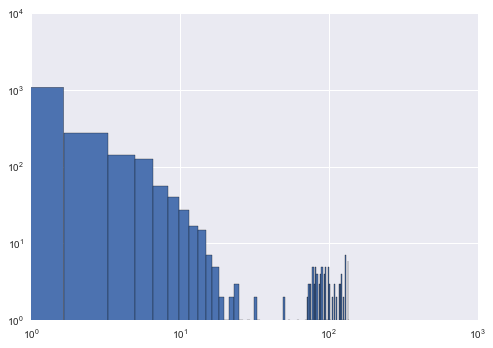

In [86]:
cities.distance.hist(bins=100)
plt.xscale('log')
plt.yscale('log')

# Scraping population data

In this section we try to map each city contained in geoinfo.csv with its overall population. We scrape the population information from the following Wikipedia [page](https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland).

In [3]:
geoinfo = pd.read_csv('geoinfo.csv',encoding='latin1')
del geoinfo['Unnamed: 0']
geoinfo.head(5)

,city,latitude,longitude,distance,runners
0,St-Légier-La Chiésaz,46.47171849999999,6.876770899999999,0.249152,12
1,St-Légier,46.47171849999999,6.876770899999999,0.249152,57
2,Ernen,46.39850010000001,8.1457733,1.518341,1
3,Lausanne,46.5196535,6.6322734,0.000000,2043
4,Pully,46.5092681,6.6654949,0.034807,312


In [4]:
import requests
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland'
r = requests.get(url)
table = pd.read_html(r.text)
table = table[1]

We are interested in the second table, which provides the relevant information. We import city name, Canton and Population for eventual visualization purposes.

In [5]:
city = table[0][2:]
city = city.reset_index(range(len(city)))
city = city.rename(columns={0 : 'name'})
del city['index']
canton = table[3][2:]
canton = canton.reset_index(range(len(city)))
canton = canton.rename(columns={3 : 'canton'})
del canton['index']
population = table[4][2:]
population = population.reset_index(range(len(city)))
population = population.rename(columns={4 : 'population'})
del population['index']

pop = pd.DataFrame()
pop['city']=city
pop['canton']=canton
pop['population']=population

In [6]:
pop.head()

,city,canton,population
0,Aarau,AG,20710
1,Aarberg,BE,4529
2,Aarburg,AG,7723
3,Adliswil,ZH,18551
4,Aesch (BL)[note 1],BL,10198


Try to link each city in *cities* with the names in *pop* through a suitable dictionary:

In [7]:
mapping = {}
for city in geoinfo.city:
    k = 0
    length = len(pop)
    while (k < length) and ((city in pop.city[k])!=True):
        k = k+1
    if k==length:
        mapping[city]='nan'
    else:
        mapping[city]=k

In [8]:
population = []
canton = []
for city in geoinfo.city:
    if mapping[city]=='nan':
        population.append('nan')
        canton.append('nan')
    else:
        population.append(pop.population[mapping[city]])
        canton.append(pop.canton[mapping[city]])
geoinfo['population']=population
geoinfo['canton']=canton

In [9]:
geoinfo.to_csv('complete_geography.csv',encoding='latin1')

# Load the complete geographical dataset

In [3]:
geography = pd.read_csv('complete_geography.csv',encoding='latin1')
del geography['Unnamed: 0']
geography.head(5)

,city,latitude,longitude,distance,runners,population,canton
0,St-Légier-La Chiésaz,46.47171849999999,6.876770899999999,0.249152,12,NaN,NaN
1,St-Légier,46.47171849999999,6.876770899999999,0.249152,57,NaN,NaN
2,Ernen,46.39850010000001,8.1457733,1.518341,1,NaN,NaN
3,Lausanne,46.5196535,6.6322734,0.000000,2043,135629,VD
4,Pully,46.5092681,6.6654949,0.034807,312,17807,VD


In [4]:
geography.population.notnull().value_counts()

False    1826
True      164
Name: population, dtype: int64

Only a few percentage of the data has been mapped into a city whose population is recorded in Wikipedia; for our qualitative purpose it should be sufficient though.

# Gravitational model and qualitative analysis

In this section we try to explore possible correlations between the number of participants to the Lausanne's Marathon and the other geographical features we have introduced.

In [5]:
# consider only nonnull entries of the dataset
geo = geography.dropna(axis=0,subset=['population','canton'])
geo.head()

,city,latitude,longitude,distance,runners,population,canton
3,Lausanne,46.5196535,6.6322734,0.000000,2043,135629,VD
4,Pully,46.5092681,6.6654949,0.034807,312,17807,VD
10,Zürich,47.3768866,8.541694,2.093021,133,396027,ZH
13,Rolle,46.4612971,6.3397549,0.298283,46,6109,VD
16,Sion,46.2331221,7.360625999999999,0.782686,53,33532,VS


In [6]:
# convert population data into integers
p = []
for pop in geo.population:
    pop = pop.replace(',','')
    pop = pop.replace('?','')
    p.append(float(pop))
P = 135629 # Lausanne's population

In [7]:
predictor = []
gamma = 1e-10 # scaling costant (only for visualization)
for j in range(len(geo)):
    predictor.append(gamma*P*p[j]/(geo.distance[geo.index[j]]*geo.distance[geo.index[j]]))
predictor = predictor[1:] # exclude Lausanne: distance = 0.00 y definition
response = list(geo.runners)
response = response[1:]

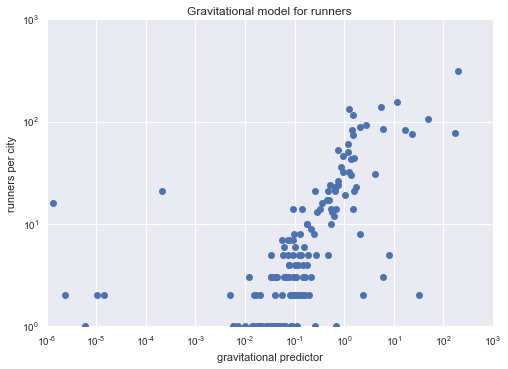

In [8]:
# scatter plot
plt.plot(predictor,response,"o")
plt.xscale('log')
plt.yscale('log')
plt.title('Gravitational model for runners')
plt.xlabel('gravitational predictor')
plt.ylabel('runners per city')

Let us now aggregate the data by Canton. The results are coherent with the logical expectations:

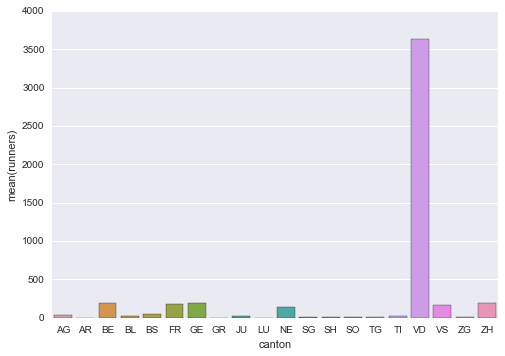

In [9]:
canton_geo = geo.groupby('canton').apply(np.sum)['runners']
sns.barplot(x=canton_geo.index, y=canton_geo)